In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from bertopic import BERTopic
import numpy as np

In [ ]:
!pip install gdown

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1i48SXwA2-KR_uyA1EaIy9Teo-zpnrhdE

Retrieving folder list
Processing file 1xsfIi_E8VJFKz_W27MjSJmAVXS3g5DoP sgns.wiki.bigram
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1xsfIi_E8VJFKz_W27MjSJmAVXS3g5DoP
To: /content/Chinese-Wiki-Pretrained/sgns.wiki.bigram
100% 1.01G/1.01G [00:15<00:00, 63.8MB/s]
Download completed


## **BERTopic for Chinese data**

In [ ]:
Chinese_df = pd.read_excel("/content/lifelong learning_Chinese.xlsx")

# delate the NA abstracts
Chinese_df.dropna(subset=['摘要'], inplace=True)

# delete rows where the character numbers are less than 15.
for index, row in Chinese_df.iterrows():
    if len(row["摘要"]) < 15:
        Chinese_df.drop(index, inplace=True)

# reset the index
Chinese_df.reset_index(drop=True, inplace=True)

Chinese_df.head(5)

,来源库,题名,作者,单位,文献来源,摘要,发表时间,年份
0,期刊,教育未来发展新趋势：迈向新人文主义的终身教育——基于联合国教科文组织前瞻性教育报告,李兴洲;徐莉;姬冰澌;,北京师范大学教育学部;河北师范大学教育学院;,清华大学教育研究,有“思想实验室”之美誉的联合国教科文组织向来以积极探索和引领人类教育前瞻性发展为己任，自20...,2023-06-20,2023
1,期刊,5G+AI:终身学习发展的新动力、新范式和新实践,钱小龙;张奕潇;,南通大学教育科学学院;,成人教育,面对党和国家完善全民终身学习体系的迫切要求，5G+AI能够扮演至关重要的角色。AI能够让提供...,2023-06-05,2023
2,期刊,欧盟成人终身学习的现状、路径与镜鉴——《欧洲成人教育和培训：构建通往技能和资格的包容性途径》...,张雪翠;卢俊林;,南宁师范大学;广西物资学校;,成人教育,终身学习是助力社会和经济进步的直接动力。欧洲联盟委员会于2021年8月发布的《欧洲成人教育和...,2023-06-05,2023
3,期刊,数字化转型助推欧盟公民终身学习能力框架：要素、实践与思考,兰国帅;黄春雨;杜水莲;李晴文;郭天雯;蔡帆帆;,河南大学教育学部;河南省教育信息化发展研究中心;温州职业技术学院瑞安学院;,开放教育研究,探明高等教育数字化转型中公民终身学习能力框架及其实践，有助于丰富高等教育数字化转型理论，促进...,2023-05-25,2023
4,期刊,OECD参与全球终身学习治理：时代轨迹、行动路径与现实影响,刘海燕;,华东师范大学教育学部教育学系;,现代远程教育研究,在经济全球化和科学技术快速发展的交叠影响下，终身学习成为一种迎接挑战的全球共识和有力举措。O...,2023-05-24,2023


In [ ]:
# input stopwords
stop_file = "/content/Chinese_stopwords.txt"

stopword_list = []
# read the stopwords.txt file
with open(stop_file, 'r', encoding='utf-8') as file:
    # read stopwords and save into the list
    for line in file:
        stopword_list.append(line.strip())  # delete empty symbols

# create the predicted topics for LDA
predict_topic_csv_path = 'topic-distribution.csv'

In [ ]:
Chinese_df['摘要'] = Chinese_df['摘要'].astype(str)   # transfer 'Abstract' into strings

# define a function to remove stopwords
def clean_text(text):
  words = jieba.lcut(text)
  words = [w for w in words if w not in stopword_list]
  return ' '.join(words)

Chinese_df["Contents"] = Chinese_df["摘要"].apply(clean_text)

Chinese_df["Contents"].head(5)

0    思想 实验室 美誉 联合国教科文组织 向来 积极探索 引领 人类 前瞻性 己任 ， 20 世...
1    面对 党和国家 全民 迫切要求 ， 5G + AI 扮演 至关重要 角色 。 AI 5G 网...
2    助力 经济 动力 。 欧洲联盟 委员会 2021 年 8 月 发布 《 欧洲 成人教育 培训...
3    探明 高等教育 数字化 转型 中 公民 能力 框架 实践 ， 有助于 高等教育 数字化 转型...
4    经济 全球化 科学技术 快速 交叠 影响 下 ， 一种 迎接挑战 全球 共识 举措 。 OE...
Name: Contents, dtype: object

In [ ]:
def chinese_word_cut(mytext):
    flag_list = ['a','ag','an','b','d','dg','h','i','j','l','n','ng','nr','nrfg','nrt','ns','nt','nz','r','rg','rr','rz','t','tg','vn']

    word_list = []

    #jieba tokenization
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        if seg_word.flag in flag_list:
            word_list.append(word)
    return (" ").join(word_list)

Chinese_df["Chinese_cutted"] = Chinese_df["Contents"].apply(chinese_word_cut)

Chinese_df["Chinese_cutted"]

0       思想 实验室 美誉 联合国教科文组织 积极探索 人类 前瞻性 己任 世纪 年代 陆续 学会 ...
1       党和国家 全民 迫切要求 至关重要 角色 网络 设备 更 驱动 体验 更 完美 时代 技术 ...
2       助力 经济 动力 欧洲联盟 委员会 欧洲 成人教育 培训 通往 技能 资格 包容性 途径 报...
3       高等教育 数字化 转型 公民 能力 框架 高等教育 数字化 转型 理论 高等教育 现代化 理...
4       经济 全球化 科学技术 快速 影响 迎接挑战 全球 共识 全球 参与者 领域 地位 日益 凸...
                              ...                        
2091    服务 社会主义 现代化 建设 传统 董明传 成人教育 形势 今后任务 成人教育 情况 青壮年...
2092    成人教育 传统 学校 新型 制度 上海市 建设 学院 理想 更新 技能 机会 院校 该院 原...
2093    概念 联合国教科文组织 富尔 报告 洛比 曾 定义 现行 制度 重组 制度 计划 学员 态度...
2094    近 国际 新兴 理论 本世纪 后半期 科学技术 生活 变化 环境 变化 新 课题 新 课题 ...
2095    科学技术 在校学生 非 人员 新 变化 现实 个体 扎实 基础知识 智力 结构 不断更新 科...
Name: Chinese_cutted, Length: 2096, dtype: object

In [ ]:
# import the pre-trained word2vec model (here we use the Chinese-Wiki pretrained model)

chinese_pretrained_model = KeyedVectors.load_word2vec_format('/content/Chinese-Wiki-Pretrained/sgns.wiki.bigram', unicode_errors='ignore')
chinese_pretrained_model

In [ ]:
topic_model = BERTopic(
    language='chinese(simplified)',
    embedding_model=chinese_pretrained_model,
    calculate_probabilities=True,
    nr_topics=20,
    verbose=True)

In [ ]:
# convert dataframe into a list
document = Chinese_df["Chinese_cutted"].tolist()

# train the model
topics, probs = topic_model.fit_transform(document)

100%|██████████| 2096/2096 [00:00<00:00, 9888.21it/s] 
2023-08-06 15:43:42,481 - BERTopic - Transformed documents to Embeddings
2023-08-06 15:43:54,564 - BERTopic - Reduced dimensionality
2023-08-06 15:43:54,865 - BERTopic - Clustered reduced embeddings
2023-08-06 15:43:55,215 - BERTopic - Reduced number of topics from 40 to 20


In [ ]:
freq = topic_model.get_topic_info(); freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,795,-1_成人教育_理念_理论_改革,"[成人教育, 理念, 理论, 改革, 国家, 影响, 基础, 学习型, 思想, 政策]",[世纪 基础 经济 时代 知识经济 时代 即将 到来 人才 日益 国家 繁荣 民族 决定性 ...
1,0,399,0_建设_思想_平台_学习型,"[建设, 思想, 平台, 学习型, 理念, 技术, 服务, 时代, 全民, 网络]",[国际性 思潮 理念 最初 理论 形态 形态 建设 学习型 体制 变革 途径 手段 远程教育...
2,1,218,1_教师_成人_高等教育_学生,"[教师, 成人, 高等教育, 学生, 大学, 课程, 高校, 高职, 自学, 考试]","[本文 大学 教师 角色定位 时代 大学 教师 职业 素质, 成人 高等教育 组成部分 全民..."
3,2,93,2_立法_法律_权利_公民,"[立法, 法律, 权利, 公民, 国家, 地方, 层面, 法规, 政策, 条例]",[理论 研究 立法 化 规范化 立法 立法 意图 文本 创设 该部 法律 调整 对象 立法 ...
4,3,69,3_生活_学校_生命_过程,"[生活, 学校, 生命, 过程, 人类, 活动, 学会, 思想, 思潮, 可持续性]",[世纪 概念 思潮 学校 学校 中心 地位 英才 价值 挑战 人 人 生活 思潮 学校 社会...
5,4,54,4_城市_学习型_建设_小康社会,"[城市, 学习型, 建设, 小康社会, 规划, 改革, 中长期, 纲要, 全民, 十六大]",[教育部 副 部长 鲁昕 国际 学习型 城市 大会 全体会议 主旨 鲁昕 副 部长 建设 学...
6,5,53,5_会议_教授_论坛_上海,"[会议, 教授, 论坛, 上海, 协会, 学院, 专家, 国际, 教育部, 成人教育]",[上海市 协会 博爱 和谐 主题 和谐社区 建设 专家 论坛 上海 田林 社区 论坛 全国政...
7,6,52,6_研究_理论_文献_分析,"[研究, 理论, 文献, 分析, 传播, 领域, 方法, 远程教育, 研究成果, 现状]",[数据库 文献 研究 可视化 软件 传统 文献 研究法 分析 结论 近十年 研究 主题 范式...
8,7,52,7_社区_居民_建设_学习型,"[社区, 居民, 建设, 学习型, 品牌, 资源, 学院, 学校, 活动, 校区]",[社区 越来越 社区 课程 社区 过程 组成部分 社区 对象 居民 建设 课程 湖州 社区 ...
9,8,51,8_资历_框架_制度_韩国,"[资历, 框架, 制度, 韩国, 标准, 学分, 质量保证, 国家, 立交桥, 资格]",[全球 跨国 跨地区 资历 新 阶段 东盟 资历 框架 建构 质量保证 系统 资历 学分 性...


In [ ]:
# the default labels for each topic
topic_model.topic_labels_

{-1: '-1_成人教育_理念_理论_改革',
 0: '0_建设_思想_平台_学习型',
 1: '1_教师_成人_高等教育_学生',
 2: '2_立法_法律_权利_公民',
 3: '3_生活_学校_生命_过程',
 4: '4_城市_学习型_建设_小康社会',
 5: '5_会议_教授_论坛_上海',
 6: '6_研究_理论_文献_分析',
 7: '7_社区_居民_建设_学习型',
 8: '8_资历_框架_制度_韩国',
 9: '9_世纪_年代_思潮_保罗',
 10: '10_职业_培训_理念_模式',
 11: '11_图书馆_公共_服务_职能',
 12: '12_政策_欧盟_成员国_工具',
 13: '13_能力_成人_研究_因子',
 14: '14_学分_银行_建设_成果',
 15: '15_老年_老年人_乡村_生活',
 16: '16_现代化_目标_历史使命_全民',
 17: '17_农村_农民_职业_诸如',
 18: '18_日本_福祉_社会教育_政策'}

In [ ]:
# visualize Topics
topic_model.visualize_topics()

In [ ]:
# visualize topic hierarchy
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=50)

In [ ]:
for i in range(19):
  print(i)
  print(topic_model.get_topic(i))

0
[('建设', 0.03517454452688443), ('思想', 0.02581455510115606), ('平台', 0.023028532015576877), ('学习型', 0.02218738049448061), ('理念', 0.022091077546915545), ('技术', 0.021833099623763123), ('服务', 0.021501363419790823), ('时代', 0.02141960524252338), ('全民', 0.020908407342009567), ('网络', 0.020838546620999727)]
1
[('教师', 0.10133158621872262), ('成人', 0.06132789308520982), ('高等教育', 0.051765896737038394), ('学生', 0.049048303988145685), ('大学', 0.048353779502681396), ('课程', 0.0391012284090615), ('高校', 0.03848669132719175), ('高职', 0.034848775268917), ('自学', 0.033241358540455845), ('考试', 0.03115453924474094)]
2
[('立法', 0.20954615736661855), ('法律', 0.07174416817258479), ('权利', 0.06578682590183381), ('公民', 0.05689774665008278), ('国家', 0.04674597867510261), ('地方', 0.046613440059346326), ('层面', 0.03597989218308507), ('法规', 0.032101830113486086), ('政策', 0.03150516714476449), ('条例', 0.030139738048802725)]
3
[('生活', 0.06777177067956912), ('学校', 0.06555403210787365), ('生命', 0.06523712564949306), ('过程', 0.050641279

In [ ]:
# similarity heatmap
topic_similar_heatmap = topic_model.visualize_heatmap(n_clusters=18)
topic_similar_heatmap.write_html('topic_similar_heatmap.html')
topic_similar_heatmap

## **LDA analysis for Chinese**

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [ ]:
n_features = 1500     # extract 1500 features
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                    max_features=n_features,
                    stop_words='english',
                    max_df = 0.5,
                    min_df = 10)
tf = tf_vectorizer.fit_transform(Chinese_df.Chinese_cutted)

In [ ]:
# perplexity curve

plexs = []
scores = []
n_max_topics = 20
for i in range(1, n_max_topics):
    print('This is the epoch: ',i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf))
    scores.append(lda.score(tf))


This is the epoch:  1
This is the epoch:  2
This is the epoch:  3
This is the epoch:  4
This is the epoch:  5
This is the epoch:  6
This is the epoch:  7
This is the epoch:  8
This is the epoch:  9
This is the epoch:  10
This is the epoch:  11
This is the epoch:  12
This is the epoch:  13
This is the epoch:  14
This is the epoch:  15
This is the epoch:  16
This is the epoch:  17
This is the epoch:  18
This is the epoch:  19


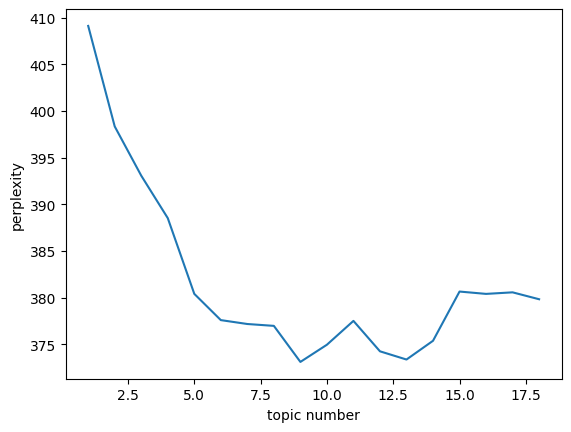

In [ ]:
n_t = 19         # set the range in x-axis
x = list(range(1,n_t))
plt.plot(x, plexs[1: n_t])
plt.xlabel("topic number")
plt.ylabel("perplexity")
plt.savefig("/content/perplexity.png", format="png", bbox_inches="tight")

# display the figure
plt.show()

In [2]:
n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                    learning_method='batch',
                    learning_offset=50,
                    doc_topic_prior=0.1,
                    topic_word_prior=0.01,
                    random_state=0)
lda.fit(tf)

In [ ]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
研究 社区 学习型 城市 能力 理论 信息 建设 分析 计划 活动 素养 国际 远程教育 上海 领域 方法 本文 教授 模型 视角 影响 特征 创业 意义
Topic #1:
高等教育 成人 模式 大学 资源 平台 社区 建设 学习者 理念 技术 课程 服务 数字化 管理 办学 系统 考试 改革 自学 环境 个性化 设计 主体 基础
Topic #2:
建设 全民 学习型 服务 高校 图书馆 老年 高职 改革 理念 现代化 目标 国家 规划 功能 院校 分析 事业 基础 特色 未来 公共 本文 高质量 老年人
Topic #3:
职业 培训 远程教育 网络 农村 信息技术 时代 人才 学校 素质 技术 企业 新型 农民 理念 技能 分析 体育 影响 群体 内容 能力 学习型 教学 建设
Topic #4:
立法 政策 法律 理念 国家 过程 日本 公民 文化 制度 价值 层面 韩国 地方 目标 学习型 权利 历史 理论 内容 建设 经验 分析 科学 基础
Topic #5:
成人教育 思想 世纪 理念 改革 世界 生活 经济 各国 人类 年代 国际 时代 知识经济 观念 影响 传统 思潮 理论 概念 联合国教科文组织 国家 变革 本文 关系
Topic #6:
教师 学生 学校 能力 自我 专业 过程 会议 理念 成人教育 理论 学院 学会 大学 教学 阶段 学习者 改革 代表 论坛 课程 职业 意识 个体 大会
Topic #7:
框架 政策 学分 资历 国家 银行 成果 建设 欧盟 制度 标准 立交桥 欧洲 分析 资格 技能 评价 国际 战略 地区 培训 各类 职业 本文 质量保证


In [ ]:
topics=lda.transform(tf)
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
Chinese_df['topic No. with the highest probabilty']=topic
Chinese_df['probability of each topic']=list(topics)
Chinese_df.to_excel("document-distribution.xlsx",index=False)

In [ ]:
def predict_to_data_frame(model: LatentDirichletAllocation, X: np.ndarray) -> pd.DataFrame:
    matrix = model.transform(X)
    columns = [f'P(topic {i+1})' for i in range(len(model.components_))]
    df = pd.DataFrame(matrix, columns=columns)
    return df

X = tf.toarray()

predict_df = predict_to_data_frame(lda, X)

predict_df.to_csv(predict_topic_csv_path, encoding='gbk', index=None)